## Sensitivity: early and late
There was a decrease in the first half of the year while after session 10 it started increasing again, 
separating those is instersting theoretically

In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os
os.chdir(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
#import cov_model_management as mm
sys.path.append(os.path.join(root_dir, "covid-fear", "lib")) 
import bammm_local as mm
import patsy
from IPython import display

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# data import
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
# hyperparameters
corr_type = "spearman" 
factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing","TF4_Physiological_Anx", "TF5_Depression", "TF6_Cognitive_Anx"]

### Model 0: traits + severity + traits * severity + (session|ID)
e.g.
$$
Worry \sim  Severity + TF_1 + TF_1*Severity  + TF_2 + TF_2*Severity + session + (session|subject) 
$$

/data/drive/postdoc/Project4_covid/output/models/model_data/severity_timewindow/F1_severity_noslope_q1_4_3000.dic
Model F1_severity_noslope_q1_4_3000 already exist, loading it.
/data/drive/postdoc/Project4_covid/output/models/model_data/severity_timewindow/F1_severity_noslope_q2_4_3000.dic
Model F1_severity_noslope_q2_4_3000 already exist, loading it.
/data/drive/postdoc/Project4_covid/output/models/model_data/severity_timewindow/F1_severity_noslope_q3_4_3000.dic
Model F1_severity_noslope_q3_4_3000 already exist, loading it.
/data/drive/postdoc/Project4_covid/output/models/model_data/severity_timewindow/F1_severity_noslope_q4_4_3000.dic
Model F1_severity_noslope_q4_4_3000 already exist, loading it.
/data/drive/postdoc/Project4_covid/output/models/model_data/severity_timewindow/F1_severity_noslope_q1_4_3000.dic
Model F1_severity_noslope_q1_4_3000 already exist, loading it.
/data/drive/postdoc/Project4_covid/output/models/model_data/severity_timewindow/F1_severity_noslope_q2_4_3000.dic
M

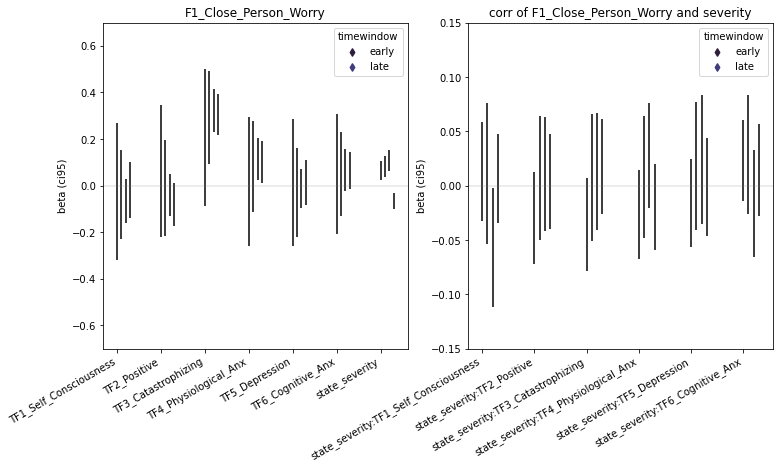

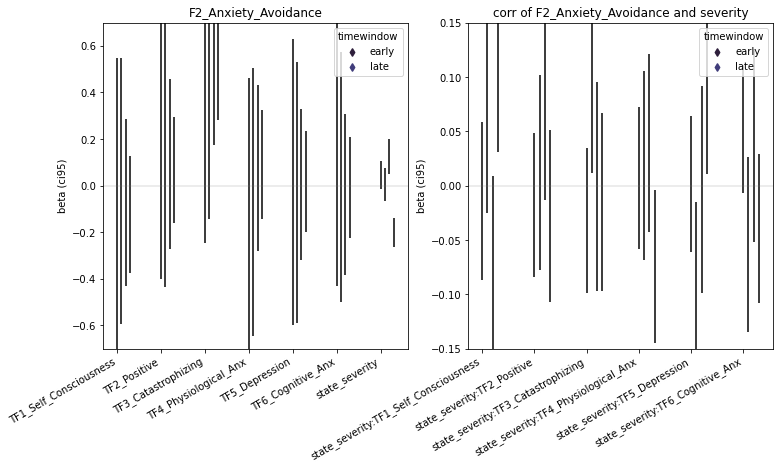

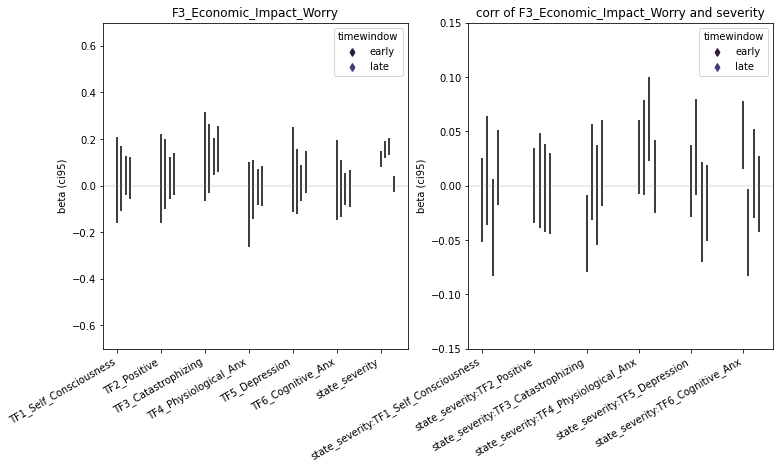

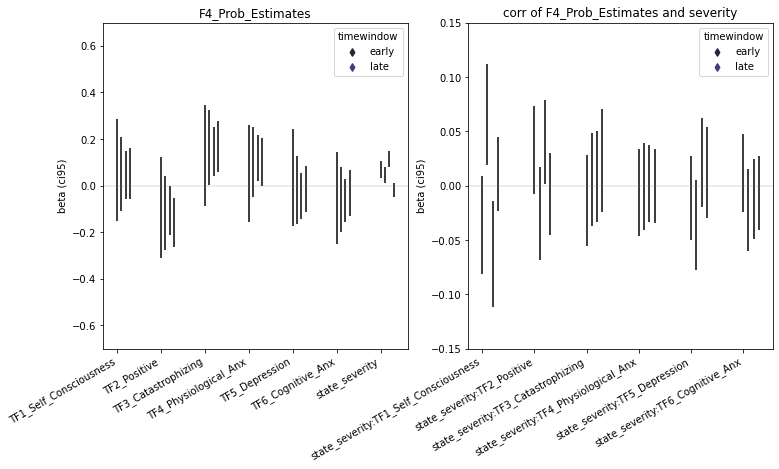

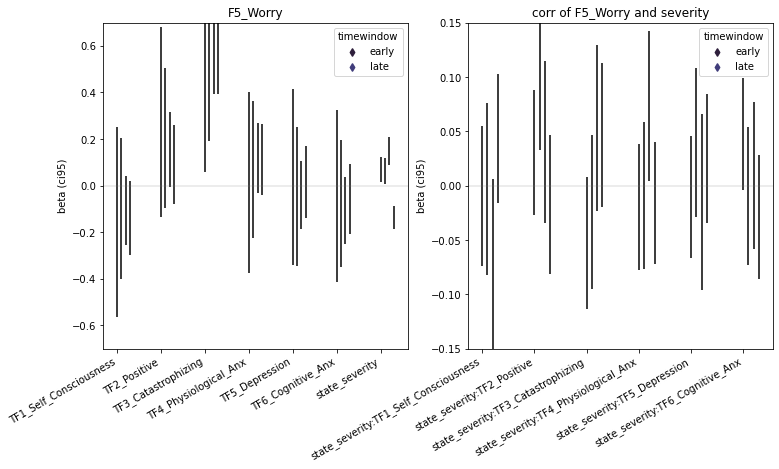

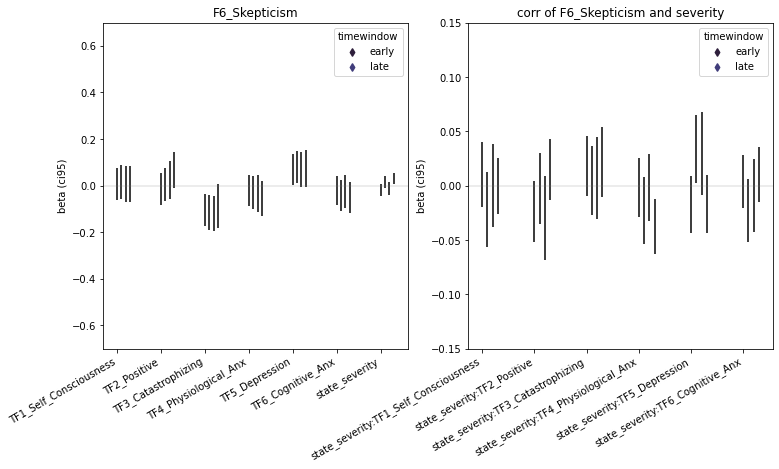

In [3]:
model_constant = "severity_noslope_"
ylims = [[-0.7,0.7], [-0.15, 0.15], [-0.02, 0.02]]
folder = "severity_timewindow"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    
    
    
  

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                        ['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            for qidx, q in enumerate(["q1", "q2", "q3", "q4"]):
                mod = models["F"+str(f_idx+1)+"_"+model_constant+q+"_4_3000"]
                # assumes that models have been estimated
                mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
                print(mod["current_sys_location"])
                mod, res,m  = mm.estimate_lmm(mod, [], override=0)
                d = res.posterior[tf].stack(draws=("chain", "draw"))
                dt = pd.DataFrame(d, columns=["sample"])
                dt.loc[:,"trait_factor"] = tf
                dt.loc[:,"timewindow"] = q
                tdf = pd.concat([tdf, dt])
                
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample", hue="timewindow", hue_order=["early", "late"],
                      data=tdf, dodge=0.15, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby(["trait_factor", "timewindow"])['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        for qidx, q in enumerate(["q1", "q2", "q3", "q4"]):  
            bounds_loc = bounds.loc[bounds["timewindow"].isin([q]),:]
            x_base = np.arange(len(bounds_loc.trait_factor))
            axs[gr_idx].vlines(x_base+0.1*qidx, bounds_loc.iloc[:,2], bounds_loc.iloc[:,3], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
        axs[gr_idx].set_ylim(ylims[gr_idx])

In [4]:
bounds = tdf.groupby(["trait_factor", "timewindow"])['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
bounds

trait_factor timewindow     0.025     0.975
0   state_severity:TF1_Self_Consciousness         q1 -0.020101  0.039729
1   state_severity:TF1_Self_Consciousness         q2 -0.056647  0.012489
2   state_severity:TF1_Self_Consciousness         q3 -0.038535  0.038203
3   state_severity:TF1_Self_Consciousness         q4 -0.026583  0.025746
4             state_severity:TF2_Positive         q1 -0.051475  0.004154
5             state_severity:TF2_Positive         q2 -0.035513  0.029718
6             state_severity:TF2_Positive         q3 -0.068795  0.008807
7             state_severity:TF2_Positive         q4 -0.013637  0.042887
10     state_severity:TF3_Catastrophizing         q3 -0.031184  0.044343
11     state_severity:TF3_Catastrophizing         q4 -0.010045  0.054150
8      state_severity:TF3_Catastrophizing         q1 -0.009498  0.045921
9      state_severity:TF3_Catastrophizing         q2 -0.026691  0.036056
12   state_severity:TF4_Physiological_Anx         q1 -0.029238  0.025582
13   state_severity:TF4_Physiological_Anx         q2 -0.053949  0.007722
14   state_severity:TF4_Physiological_Anx         q3 -0.032815  0.029115
15   state_severity:TF4_Physiological_Anx         q4 -0.062513 -0.012218
16          state_severity:TF5_Depression         q1 -0.043751  0.008669
17          state_severity:TF5_Depression         q2  0.002054  0.064715
18          state_severity:TF5_Depression         q3 -0.008299  0.068026
19          state_severity:TF5_Depression         q4 -0.043677  0.009569
22       state_severity:TF6_Cognitive_Anx         q3 -0.042958  0.024129
20       state_severity:TF6_Cognitive_Anx         q1 -0.020626  0.027966
21       state_severity:TF6_Cognitive_Anx         q2 -0.052128  0.006486
23       state_severity:TF6_Cognitive_Anx         q4 -0.015023  0.035801